In [256]:
# read the file : df

columns_to_drop = ['height','kg','lmp','edd','indication','diagnosis','usg','filename','FHR','Grade','A.F.I', 'Placenta','Cervix_Length','maternal_request','hhh','bg']
df_upd =df.drop(columns=columns_to_drop)
df_upd = df_upd[~df_upd.delivery_mode.isna()]
df_upd['cervix_numerical'] = np.where((df_upd.cervix_numerical=='32') | (df_upd.cervix_numerical=='normal'),3.2,df_upd.cervix_numerical)
df_upd['cervix_numerical'] = np.where(df_upd.cervix_numerical=='3.44.8','3.4',df_upd.cervix_numerical)
df_upd['cervix_numerical'] = np.where(df_upd.cervix_numerical=='',np.NAN,df_upd.cervix_numerical)
df_upd['cervix_numerical'] = df_upd['cervix_numerical'].astype(float)

# impute ga_weeks
cl_impute = df_upd[~df_upd.cervix_numerical.isna()].groupby('ga_weeks')['cervix_numerical'].mean().reset_index().rename(columns={'cervix_numerical':'impute_mean'})
df_upd_merge = df_upd.merge(cl_impute, on = ['ga_weeks'])
df_upd_merge['upd_cervix_length'] = df_upd_merge['cervix_numerical'].fillna(df_upd_merge['impute_mean'])
df_upd_merge.drop(columns=['cervix_numerical'],inplace=True)
# df_upd_merge.upd_cervix_length.hist()

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='19 3.8','19', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='11 5','11', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='6 7','6', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='16 1','16', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='11 7','11', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='10 7','10', df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='10. 0','10', df_upd_merge['A.F.I_numerical'])

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='ADEQUATE','10', df_upd_merge['A.F.I_numerical'])

df_upd_merge['A.F.I_numerical'] = np.where(df_upd_merge['A.F.I_numerical']=='',np.NaN, df_upd_merge['A.F.I_numerical'])
df_upd_merge['A.F.I_numerical'] = df_upd_merge['A.F.I_numerical'].astype(float)
df_upd_merge[~df_upd_merge['A.F.I_numerical'].isna()].groupby('ga_weeks')['A.F.I_numerical'].mean().reset_index().rename(columns={'A.F.I_numerical':'impute_mean_afi'})

cl_impute = df_upd_merge[~df_upd_merge['A.F.I_numerical'].isna()].groupby('ga_weeks')['A.F.I_numerical'].mean().reset_index().rename(columns={'A.F.I_numerical':'impute_mean_afi'})
df_upd_merge = df_upd_merge.merge(cl_impute, on = ['ga_weeks'])
df_upd_merge['upd_afi'] = df_upd_merge['A.F.I_numerical'].fillna(df_upd_merge['impute_mean'])
df_upd_merge.drop(columns=['A.F.I_numerical'],inplace=True)
df_upd_merge['age'] = df_upd_merge['age'].fillna(df_upd_merge[~df_upd_merge.age.isna()].age.mean())
df_upd_merge['E.F.W'] = np.where(df_upd_merge['E.F.W']=='nan',np.NaN, df_upd_merge['E.F.W'])
df_upd_merge = df_upd_merge.reset_index().drop(columns=['patient_id']).rename(columns={'index':'patient_id'})

df_upd_merge['E.F.W'] = df_upd_merge['E.F.W'].astype(float)
print(df_upd_merge[~df_upd_merge['E.F.W'].isna()][['age','height_upd','E.F.W','kg_upd','ga_weeks']].corr())

from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = df_upd_merge[(~df_upd_merge['E.F.W'].isna()) & (df_upd_merge['E.F.W']>10)][['patient_id','age','height_upd','kg_upd','ga_weeks']]
y= df_upd_merge[(~df_upd_merge['E.F.W'].isna()) & (df_upd_merge['E.F.W']>10)]['E.F.W']
model.fit(X.drop(columns =['patient_id']), y)
# predicted_y = model.predict(new_X)
new_X =  df_upd_merge[(df_upd_merge['E.F.W'].isna()) | (df_upd_merge['E.F.W']<=10)][['patient_id','age','height_upd','kg_upd','ga_weeks']]
predicted_y = model.predict(new_X.drop(columns=['patient_id']))

df_upd_merge_imputed = df_upd_merge.merge(
    pd.concat([new_X.reset_index(), pd.DataFrame(predicted_y)], axis=1).rename(columns={0: 'predicted_efw'})[['patient_id','predicted_efw']],
    on=['patient_id'], how='left')
df_upd_merge_imputed['efw_upd'] = df_upd_merge_imputed['E.F.W'].fillna(df_upd_merge_imputed['predicted_efw'])
df_upd_merge_imputed['efw_upd'] = np.where(df_upd_merge_imputed['E.F.W']<10, df_upd_merge_imputed['predicted_efw'], df_upd_merge_imputed['efw_upd'])
df_upd_merge_imputed['efw_upd'] = np.where(df_upd_merge_imputed['E.F.W']<10, df_upd_merge_imputed['predicted_efw'], df_upd_merge_imputed['efw_upd'])
df_upd_merge_imputed.drop(columns=['E.F.W'],inplace=True)
df_upd_merge_imputed.drop(columns=['predicted_efw'],inplace=True)
df_upd_merge_imputed.isna().mean()

                 age  height_upd     E.F.W    kg_upd  ga_weeks
age         1.000000    0.070862 -0.025027  0.110673 -0.036083
height_upd  0.070862    1.000000 -0.010117  0.250973  0.027798
E.F.W      -0.025027   -0.010117  1.000000  0.033228  0.358850
kg_upd      0.110673    0.250973  0.033228  1.000000  0.028554
ga_weeks   -0.036083    0.027798  0.358850  0.028554  1.000000


patient_id           0.000000
age                  0.000000
hb                   0.000000
bp                   0.000000
ga_weeks             0.000000
delivery_mode        0.000000
prvs_lscs            0.000000
prvs_abortion        0.000000
oligo                0.000000
meconium             0.000000
iugr                 0.000000
gdm                  0.000000
hyperthyraidisim     0.000000
fetus_type           0.000000
kg_upd               0.000000
height_upd           0.000000
bmi                  0.000000
FUNDAL               0.000000
FUNDO-ANTERIOR       0.000000
POSTERIOR            0.000000
ANTERIOR             0.000000
LEFT                 0.000000
RIGHT                0.000000
fhr_upd              0.595174
impute_mean          0.000000
upd_cervix_length    0.000000
impute_mean_afi      0.000000
upd_afi              0.000000
efw_upd              0.000000
dtype: float64

In [261]:
df_upd_merge_imputed_ohe = pd.get_dummies(df_upd_merge_imputed,columns=['fetus_type','delivery_mode'], prefix = ['fetus_type','delivery_mode'], drop_first=True)
df_upd_merge_imputed_ohe

,patient_id,age,hb,ga_weeks,prvs_lscs,prvs_abortion,oligo,meconium,iugr,gdm,hyperthyraidisim,kg_upd,height_upd,bmi,FUNDAL,FUNDO-ANTERIOR,POSTERIOR,ANTERIOR,LEFT,RIGHT,upd_cervix_length,upd_afi,efw_upd,fetus_type_THREE,fetus_type_TWIN,delivery_mode_NVD
0,0,39.0,10.6,37.0,1,0,0,0,0,0,0,77.000000,0.770000,129.870130,1,0,0,0,0,0,3.45,15.4,3044.000000,0,0,0
1,1,32.0,9.3,37.0,1,0,0,0,0,0,1,79.000000,0.790000,126.582278,0,0,0,1,0,0,3.60,10.1,2176.000000,0,0,0
2,2,31.0,10.3,37.0,0,0,0,0,0,0,0,62.000000,0.620000,161.290323,0,0,1,0,0,0,3.45,6.4,3110.000000,0,0,0
3,3,28.0,12.2,37.0,0,0,0,0,0,0,1,40.000000,0.400000,250.000000,1,0,0,1,0,0,3.40,9.3,1370.000000,0,0,1
4,4,31.0,11.1,37.0,0,0,0,0,0,0,0,71.000000,0.710000,140.845070,0,0,0,1,0,0,4.30,10.9,2862.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,741,22.0,10.8,25.0,0,0,0,0,0,0,0,68.000000,0.680000,147.058824,0,0,1,0,0,0,4.80,14.0,333.000000,0,0,0
742,742,29.0,10.8,25.0,0,0,0,0,0,0,0,60.000000,0.600000,166.666667,0,0,1,0,0,0,4.10,5.5,506.926317,0,0,1
743,743,32.0,11.1,25.0,0,0,0,0,0,0,0,75.364370,1.567368,30.677805,0,0,0,0,0,0,4.10,4.1,650.336564,0,0,1
744,744,32.0,11.5,23.0,0,0,0,0,0,0,1,55.000000,0.550000,181.818182,0,0,0,1,0,0,1.60,11.1,714.000000,0,1,1


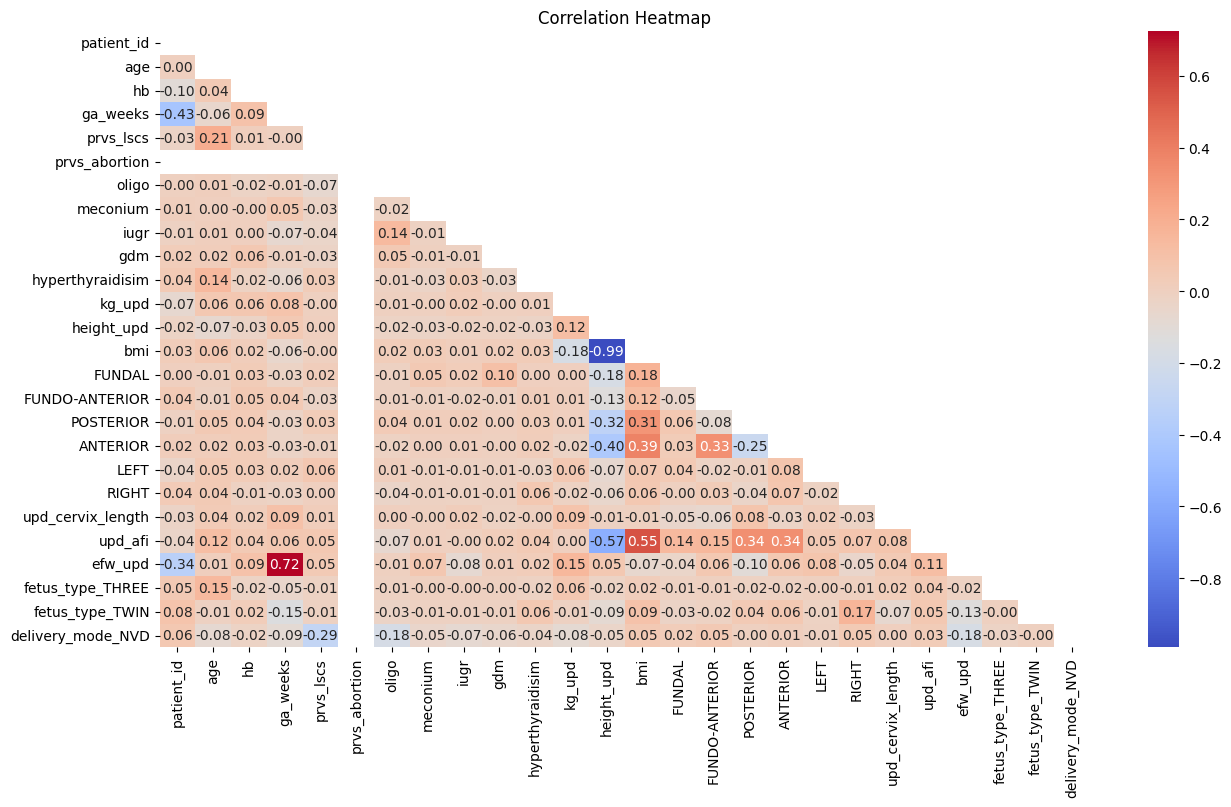

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix  = df_upd_merge_imputed_ohe.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask =  mask)
plt.title('Correlation Heatmap')
plt.show()

In [270]:
from sklearn.model_selection import train_test_split

X = df_upd_merge_imputed_ohe.drop(columns=['patient_id','delivery_mode_NVD'])
y = df_upd_merge_imputed_ohe['delivery_mode_NVD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.value_counts(), y_test.value_counts())

(596, 24) (150, 24)
0    391
1    205
Name: delivery_mode_NVD, dtype: int64 0    101
1     49
Name: delivery_mode_NVD, dtype: int64


In [273]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 11, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3, verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['log2', 'sqrt'], 'max_depth': [5, 6, 7, 8, 9, 11, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warn

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 9, 11, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

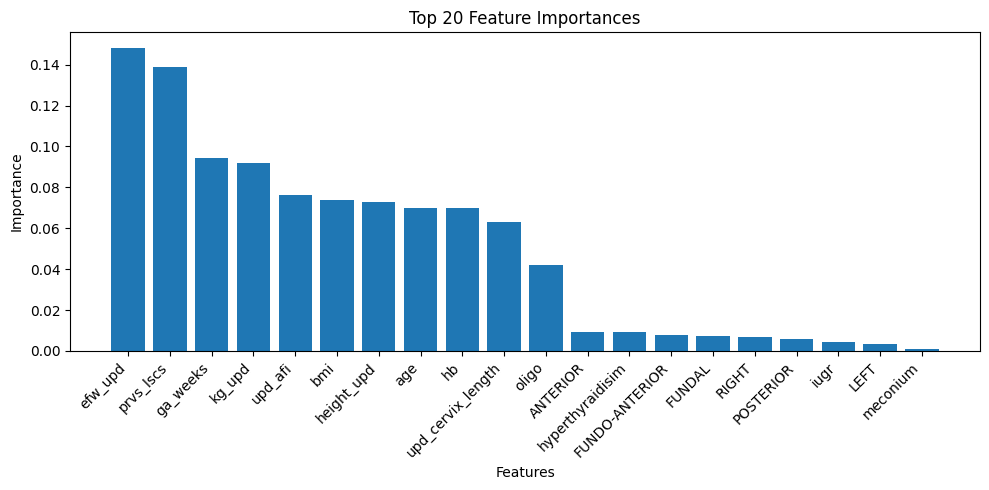

In [276]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_random, feature_names, and X_train are already defined
best_random = rf_random.best_estimator_
feature_names = X_train.columns.tolist()
# Get feature importances
importances = best_random.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Get the feature names, sorted by importance
names = [feature_names[i] for i in indices]

# Number of features to display
num_features = 20

# Limit the data to the top 'num_features' features
sorted_importances = importances[indices[:num_features]]
sorted_names = [names[i] for i in range(num_features)]

# Create the plot
plt.figure(figsize=(10, 5))
plt.title("Top 20 Feature Importances")
plt.bar(range(num_features), sorted_importances)
plt.xticks(range(num_features), sorted_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

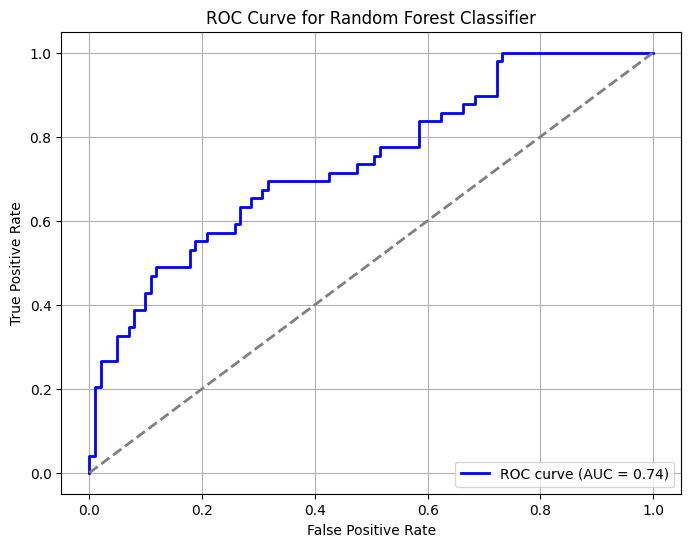

In [277]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = best_random.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()